In [ ]:
##importing necessary libraries and the train data
import nltk
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import utils
from matplotlib import pyplot as plt
import seaborn as sns
import  time
##import warnings
##warnings.filterwarnings(action = 'ignore')
import gensim
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
nltk.download('brown')
nltk.download('universal_tagset')
from nltk.corpus import brown
brown_tagged =brown.tagged_sents( tagset='universal')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


In [ ]:
brown_train,brown_test =train_test_split(brown_tagged,train_size=0.80,test_size=0.20,random_state = 102)
brown_tagged_words=[]
brown_tagged_tags=[]
for sentence in brown_tagged:
  word_sentence=[]
  tag_sentence=[]
  for words in sentence:
    word_sentence.append(words[0])
    tag_sentence.append(words[1])
  brown_tagged_words.append(word_sentence)
  brown_tagged_tags.append(tag_sentence)


In [ ]:
print(brown_tagged_words[0],brown_tagged_tags[20])

['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.'] ['DET', 'NOUN', 'VERB', 'PRON', 'VERB', 'DET', 'NOUN', '.', 'VERB', 'VERB', 'ADP', 'DET', 'VERB', 'NOUN', 'DET', 'NOUN', '.', 'ADP', 'NUM', 'ADJ', 'ADJ', 'NOUN', '.', 'DET', 'NOUN', 'NOUN', 'NOUN', 'CONJ', 'DET', 'NOUN', 'NOUN', 'NOUN', '.']


In [ ]:
##encoding the words and tags to unique numbers because nn will work with numbers
'''det =5
   noun=1
   adv = 7
   verb =2
   adp=4
   adj=6
   .=3
   conj=9
   pron=8
   prt=10
   num=11
   x=12'''
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(brown_tagged_words)
brown_tagged_words_encoded = word_tokenizer.texts_to_sequences(brown_tagged_words)

tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(brown_tagged_tags)
brown_tagged_tags_encoded = tag_tokenizer.texts_to_sequences(brown_tagged_tags)
print(brown_tagged_tags_encoded[5][0],brown_tagged_tags_encoded[5][7],brown_tagged_tags_encoded[20][18],brown_tagged_tags_encoded[1][10])

8 10 11 6


In [ ]:
print(brown_tagged_tags_encoded[20][0],brown_tagged_tags_encoded[20][5],brown_tagged_tags_encoded[20][18],brown_tagged_tags_encoded[1][10])

5 5 11 6


Length of longest sentence: 180


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


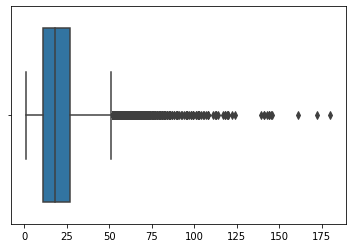

In [ ]:
## we will pad now
lengths = [len(seq) for seq in brown_tagged_words_encoded]
print("Length of longest sentence: {}".format(max(lengths)))
sns.boxplot(lengths)
plt.show()

In [ ]:
MAX_SEQ_LENGTH = 100
brown_tagged_words_padded = pad_sequences(brown_tagged_words_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
brown_tagged_tags_padded = pad_sequences(brown_tagged_tags_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
print(brown_tagged_tags_padded[0])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 5 1 1 6 1 2 1 5 1 4 1 6 1 1 2 3 5 1 3 4 5 1 2 1 3]


Implementing word2vector

In [ ]:
path = "GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin"
word2vec= KeyedVectors.load_word2vec_format(path, binary=True)
EMBEDDING_SIZE  = 300
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1
embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))
word2id = word_tokenizer.word_index
for word, index in word2id.items():
    try:
        embedding_weights[index, :] = word2vec[word]
    except KeyError:
        pass

FileNotFoundError: ignored

In [ ]:
print(brown_tagged_tags_padded.shape)

(57340, 100)


One-hot representation for tags since it has less no. of tags

In [ ]:
from tensorflow.keras.utils import to_categorical
brown_tagged_tags_padded = to_categorical(brown_tagged_tags_padded)
#print(len(brown_tagged_tags),brown_tagged_tags_padded[0])

In [ ]:
print(brown_tagged_tags_padded[0][75])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
from keras import models
from keras import layers
from tensorflow.keras.layers import Embedding
import numpy as np
print(len(brown_tagged_words))
len_brown_data=len(brown_tagged_words_padded)/5
avg_loss=0.0
avg_acc=0.0
for i in range(5):
    first_part=int(i*(len_brown_data))
    second_part=int((i+1)*len_brown_data)
    X_train=np.concatenate((brown_tagged_words_padded[:first_part],brown_tagged_words_padded[second_part:]),axis=0)
    X_test =brown_tagged_words_padded[first_part:second_part]
    Y_train=np.concatenate((brown_tagged_tags_padded[:first_part],brown_tagged_tags_padded[second_part:]),axis=0)
    Y_test =brown_tagged_tags_padded[first_part:second_part]
    network = models.Sequential() ## starting the ffnn
    network.add(Embedding(input_dim     = VOCABULARY_SIZE,
                             output_dim    = EMBEDDING_SIZE,
                             input_length  = MAX_SEQ_LENGTH,
                             weights       = [embedding_weights],
                             trainable     = True))
    network.add(layers.Dense(units=100, activation='relu'))
    network.add(layers.Dense(units=13, activation='softmax'))
    network.compile(loss='categorical_crossentropy', # Cross-entropy
                optimizer='rmsprop', # Root Mean Square Propagation
                metrics=['accuracy'])
    trainng = network.fit(X_train,Y_train,batch_size=128,epochs=10,validation_data=(X_test, Y_test))
    loss,accuracy = network.evaluate(X_test,Y_test,verbose=1)
    avg_loss=avg_loss+loss
    avg_acc=avg_acc+accuracy
avg_loss=avg_loss/5.0
avg_acc=avg_acc/5.0
print(avg_loss,avg_acc)


57340


NameError: ignored

In [ ]:
'''X_train,X_test,Y_train,Y_test=train_test_split(brown_tagged_words_padded,brown_tagged_tags_padded,test_size=0.20,random_state = 102)
X_train,X_validation,Y_train,Y_validation=train_test_split(X_train,Y_train,test_size=0.20,random_state = 102)'''

In [ ]:
'''from keras import models
from keras import layers
from tensorflow.keras.layers import Embedding

network = models.Sequential() ## starting the ffnn
network.add(Embedding(input_dim     = VOCABULARY_SIZE,
                             output_dim    = EMBEDDING_SIZE,
                             input_length  = MAX_SEQ_LENGTH,
                             weights       = [embedding_weights],
                             trainable     = True
))
network.add(layers.Dense(units=100, activation='relu'))
network.add(layers.Dense(units=13, activation='softmax'))


'''

In [ ]:
'''network.compile(loss='categorical_crossentropy', # Cross-entropy
                optimizer='rmsprop', # Root Mean Square Propagation
                metrics=['accuracy'])'''

In [ ]:
'''trainng = network.fit(X_train,Y_train,batch_size=128,epochs=10,validation_data=(X_validation, Y_validation))'''

In [ ]:
'''loss,accuracy = network.evaluate(X_test,Y_test,verbose=1)
print(loss,accuracy)'''

In [ ]:
print(Y_test[0][0])

In [ ]:
print(X_test[0].shape)

In [ ]:
sentence=input()

In [ ]:
import tensorflow as tf
def sen_vec(sent):
    words=sent.split(" ")
    l = []
    for i in range(len(words)):
        x=0
        for j in range(len(brown_tagged_words_encoded)):
            for k in range(len(brown_tagged_words_encoded[j])):
                if(x==0 and words[i]==brown_tagged_words[j][k]):
                    l.append(int(brown_tagged_words_encoded[j][k]))
                    x=1
                    break
            if(x==1):
                break
    t=tf.convert_to_tensor(l)
    t=tf.reshape(t, [1, t.shape[0]])
    y = pad_sequences(t, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
    return y




In [ ]:
l=[]
l=sen_vec(sentence)
print(l.shape,l)

In [ ]:
dict={5:"det",1:"noun",7:"adv" ,2:"verb",4:"adp",6:"adj",3:".",9:"conj",8:"pron" ,10:"prt",11:"num",12:"X"}


In [ ]:
pred=network.predict(l)
ans=[]
x=sentence.split(" ")
start=MAX_SEQ_LENGTH-len(x)
print(pred.shape)
for i in range(start,MAX_SEQ_LENGTH):
    indices = tf.argmax(pred[0][i])
    c = tf.keras.backend.eval(indices)
    ans.append(dict[c])
print(ans)
